In [1]:
import torch
from transformers import AutoTokenizer, EsmForMaskedLM
from transformers.models.esm.openfold_utils.protein import to_pdb, Protein as OFProtein
from transformers.models.esm.openfold_utils.feats import atom14_to_atom37
import torch.nn as nn

from pyJoules.energy_meter import EnergyContext
from pyJoules.device.rapl_device import RaplPackageDomain
from pyJoules.device.nvidia_device import NvidiaGPUDomain
from pyJoules.handler.csv_handler import CSVHandler
from pyJoules.energy_meter import measure_energy

from Bio import SeqIO
import pandas as pd
import numpy as np
from time import perf_counter_ns
import matplotlib.pyplot as plt
import gc

SEQ_MAX_LEN = 8096

c:\Users\lgltan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### CUDA/Torch GPU Setup

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 4060 Ti


## Convert FASTA file to pd.DataFrame for easier processing

In [3]:
def fasta_to_dataframe(fasta_file):
    records = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):
        if len(records) >= 10000:
            break
        # Extract the ID after '>tr'
        id_info = seq_record.id.split('|')[1] # Adjust the index based on your FASTA file format
        sequence = str(seq_record.seq)
        
        # Generate a random index within the range of the sequence length
        random_index = np.random.randint(0, min(len(sequence), SEQ_MAX_LEN))
        # Replace the character at the random index with '<mask>'
        masked_sequence = sequence[:random_index] + '<mask>' + sequence[random_index+1:]
        
        records.append([id_info, sequence, masked_sequence])
    
    # Create a DataFrame from the records
    df = pd.DataFrame(records, columns=['ID', 'Sequence', 'Masked_Sequence'])
    return df

## Create Dataset

In [4]:
fasta_df = fasta_to_dataframe("human_protein_seq/uniprotkb_proteome_UP000005640.fasta")

In [5]:
fasta_df.head()

,ID,Sequence,Masked_Sequence
0,A0A075B6G3,MLWWEEVEDCYEREDVQKKTFTKWVNAQFSKFGKQHIENLFSDLQD...,MLWWEEVEDCYEREDVQKKTFTKWVNAQFSKFGKQHIENLFSDLQD...
1,A0A087WV00,MDAAGRGCHLLPLPAARGPARAPAAAAAAAASPPGPCSGAACAPSA...,MDAAGRGCHLLPLPAARGPARAPAAAAAAAASPPGPCSGAACAPSA...
2,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,M<mask>LSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS
3,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
4,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...


In [6]:
fasta_df.shape

(10000, 3)

## Preparing your model and tokenizer

Now we load our model and tokenizer. If using GPU, use `model.cuda()` to transfer the model to GPU.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D")

In [8]:
# Ensure the model is in evaluation mode
model.eval()

model.to(device)

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_a

In [9]:
print(f"Running test on {fasta_df.shape[0]} sequences.")

# set up accuracy & latency info - leave this in the same code block so that it resets each time
accuracy = []
latency = pd.DataFrame(columns=['start', 'tokenize', 'move_to_gpu', 'model', "end"])
sequence_length = []
memory_usage = []
ctr = 0

gc.collect()
# initial memory usage without the thing running
memory_usage.append(torch.cuda.memory_allocated())
loss_fn = nn.CrossEntropyLoss()

@measure_energy
def run(accuracy, latency, memory_usage):
    latency_time_stamps = []
    # TIME LOG: start
    latency_time_stamps.append(perf_counter_ns())

    # Tokenize the input and move it to the correct device
    inputs = tokenizer(fasta_row["Masked_Sequence"], max_length=min(len(fasta_row["Masked_Sequence"]), SEQ_MAX_LEN), truncation=True, return_tensors='pt')
    
    # TIME LOG: tokenize
    latency_time_stamps.append(perf_counter_ns())
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # TIME LOG: move_to_gpu
    latency_time_stamps.append(perf_counter_ns())
    
    with torch.no_grad():
        logits = model(**inputs).logits
    
    # TIME LOG: model
    latency_time_stamps.append(perf_counter_ns())
    
    unmasked_text = fasta_row['Sequence']
    masked_text = fasta_row["Masked_Sequence"]
    mask_position = masked_text.find('<mask>')
    actual_token = unmasked_text[mask_position]
    
    # Convert the actual token to its corresponding ID
    actual_token_id = tokenizer.encode(actual_token, add_special_tokens=False)[0]

    # Prepare the target tensor
    target = torch.tensor([actual_token_id] + np.zeros(33, dtype=np.longlong), device=device).unsqueeze(0)
    
    # Calculate the cross-entropy loss
    loss = loss_fn(logits, target)

    # TIME LOG: end
    latency_time_stamps.append(perf_counter_ns())

    # Append the loss to a list or use it as needed
    accuracy.append(loss.item())
        
    memory_usage.append(torch.cuda.memory_allocated())

    latency.loc[len(latency.index)] = latency_time_stamps

for id, fasta_row in fasta_df.iterrows():
    ctr += 1
    if ctr % 100 == 0:
        percentage = "{:.2f}".format(ctr * 100 / fasta_df.shape[0])
        print(f"Processing... {percentage}%")
        
    sequence_length.append(len(fasta_row["Sequence"]))
    
    # try to save as much memory as possible by reducing fragmentation
    torch.cuda.empty_cache()
    
    # load model to GPU
    model.to(device)

    run(accuracy, latency, memory_usage)
    
    # try to remove anything no longer needed on the GPU mem
    gc.collect()

Running test on 10000 sequences.
begin timestamp : 1711124595.3120468; tag : run; duration : 0.29093050956726074; nvidia_gpu_0 : 22212
begin timestamp : 1711124595.6795952; tag : run; duration : 0.026805877685546875; nvidia_gpu_0 : 3070
begin timestamp : 1711124595.7594743; tag : run; duration : 0.013303041458129883; nvidia_gpu_0 : 4609
begin timestamp : 1711124595.8677185; tag : run; duration : 0.012633085250854492; nvidia_gpu_0 : 0
begin timestamp : 1711124595.9484446; tag : run; duration : 0.012025594711303711; nvidia_gpu_0 : 0
begin timestamp : 1711124596.0213244; tag : run; duration : 0.014097452163696289; nvidia_gpu_0 : 0
begin timestamp : 1711124596.0974584; tag : run; duration : 0.015224456787109375; nvidia_gpu_0 : 0
begin timestamp : 1711124596.1744525; tag : run; duration : 0.0; nvidia_gpu_0 : 1874
begin timestamp : 1711124596.2488801; tag : run; duration : 0.01629328727722168; nvidia_gpu_0 : 0
begin timestamp : 1711124596.3290763; tag : run; duration : 0.0; nvidia_gpu_0 : 0


In [10]:
print(len(sequence_length))

10000


## Accuracy Log

In [11]:
print("Correctly Predicted: " + str(sum(accuracy)))
print("Total Runs: " + str(len(accuracy)))
print("Accuracy: " +  str(sum(accuracy)/len(accuracy)))

Correctly Predicted: 88877.86320543289
Total Runs: 10000
Accuracy: 8.88778632054329


## Latency/Time Log

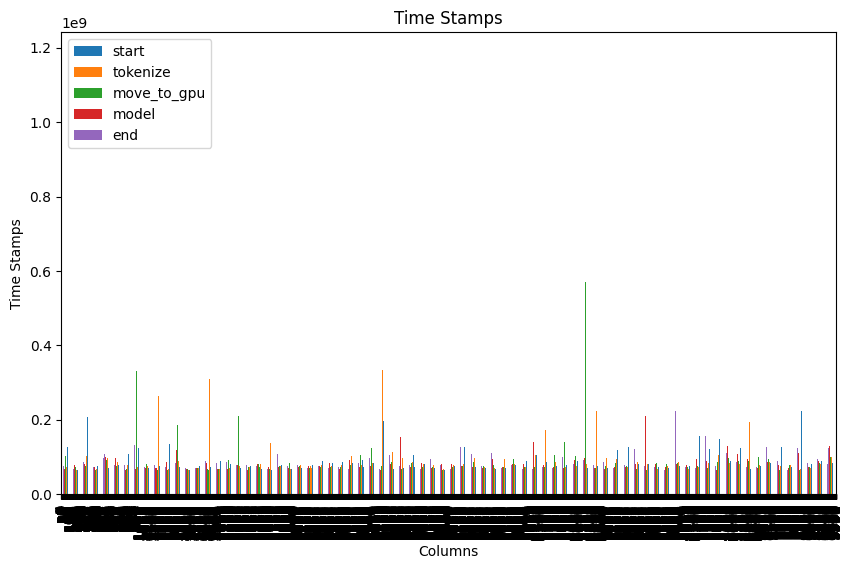

In [12]:
# drop headers
latency_diff = latency.diff().dropna()

latency_diff.plot(kind='bar', figsize=(10, 6))
plt.title('Time Stamps')
plt.xlabel('Columns')
plt.ylabel('Time Stamps')
plt.show()

In [13]:
# Calculate total latency
total_latency = latency['cmp_sequences'] - latency['start']

# Merge the total latency with sequence_length DataFrame
lat_len_df = pd.DataFrame({ "Latency": total_latency, "Sequence_Length": sequence_length})

# Plotting sequence length vs total latency
lat_len_df.plot(x='sequence_length', y='total_latency', kind='scatter', figsize=(10, 6))
plt.title('Latency Graph of Sequence Length vs Total Latency')
plt.xlabel('Sequence Length')
plt.ylabel('Total Latency')
plt.show()

KeyError: 'cmp_sequences'